#### Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
import numpy as np

## Twitter Data

### Dataset loading

Link to dataset: https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [2]:
tweets_path = "Datasets/kaggle/Tweet.csv"
id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
ticker_to_name_path = "Datasets/kaggle/Company.csv"

#### Dataframe creation

We have 3 csv files: 
- Tweet.csv contains information about tweets (text, stats, unique id)
- Company_Tweet.csv mathches each unique id with a ticker symbol
- Company.csv matches company name with it's ticker symbol (some companies can have multipple tickers like $GOOG and $GOOGL for Google Inc.)

In [3]:
tweets_df = pd.read_csv(tweets_path)
tickers_df = pd.read_csv(id_to_ticker_path)
company_name_df = pd.read_csv(ticker_to_name_path)

In [4]:
tweets_df.post_date = pd.to_datetime(tweets_df.post_date, unit='s', origin='unix') # Converting to datetime
tweets_df.head(10)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
5,550443808606126081,aaplstocknews,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
6,550443809700851716,iknowfirst,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
7,550443857142611968,Cprediction,2015-01-01 00:10:16,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
8,550443857595600896,iknowfirst_br,2015-01-01 00:10:17,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
9,550443857692078081,Gold_prediction,2015-01-01 00:10:17,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


Here we can already see tweets with duplicate bodies, something to take care of in data cleaning step.

### Data exploration

In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   tweet_id     int64         
 1   writer       object        
 2   post_date    datetime64[ns]
 3   body         object        
 4   comment_num  int64         
 5   retweet_num  int64         
 6   like_num     int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 198.6+ MB


In [6]:
tweets_df.shape

(3717964, 7)

In [7]:
tweets_df.nunique()

tweet_id       3717964
writer          140131
post_date      3421363
body           3326194
comment_num        191
retweet_num        509
like_num           783
dtype: int64

In [8]:
tweets_df.post_date.min(), tweets_df.post_date.max()

(Timestamp('2015-01-01 00:00:57'), Timestamp('2019-12-31 23:55:53'))

We have a total of 3.717.964 tweets in our dataset from 140.131 writers. This means that significant amount of tweets are written by the same accounts through the period from the beggining of 2015 to the end of 2019.

In [9]:
tweets_df.apply(lambda x: sum(x.isna()) / len(tweets_df))

tweet_id       0.000000
writer         0.012715
post_date      0.000000
body           0.000000
comment_num    0.000000
retweet_num    0.000000
like_num       0.000000
dtype: float64

Less than 1% of NaN values only in writer column.

In [10]:
# Top 20 writers by number of tweets
tweets_df.writer.value_counts()[:20]

App_sw_            91741
_peripherals       91461
computer_hware     90919
It_c0nsulting      75270
PortfolioBuzz      59838
retail_Dbt         44174
MacHashNews        42190
ExactOptionPick    22084
markbspiegel       18228
davidmoadel        15553
OACtrading         14432
SeekingAlpha       13970
treabase           13828
rosnerstocks       13461
PolgarStocks       13370
Commuternyc        13241
IHNewsDesk         13226
JohnyTradr         12419
TalkMarkets        11685
Benzinga           10791
Name: writer, dtype: int64

In [11]:
sum(tweets_df.writer.value_counts() == 1) # tweeted only once

77577

Number of tweets per week and date:

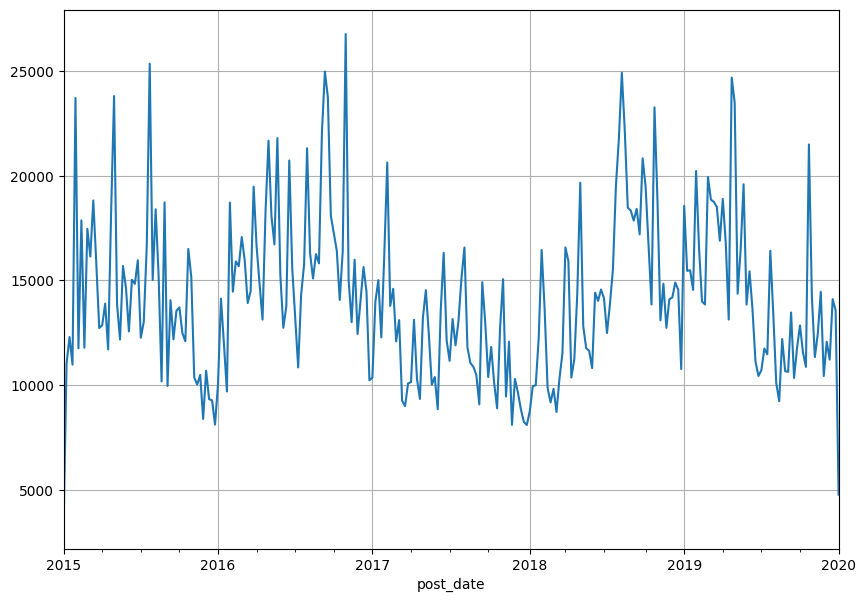

In [12]:
tweets_df.groupby(pd.Grouper(key='post_date', axis=0, freq='1w')).count()['tweet_id'].plot(grid=True, figsize=(10,7));

We can see that nearing the end of the year the number of tweets decreases, possiblu because of long holidays when the markets are closed.

Number of tweets to character length:

122.04350799384774

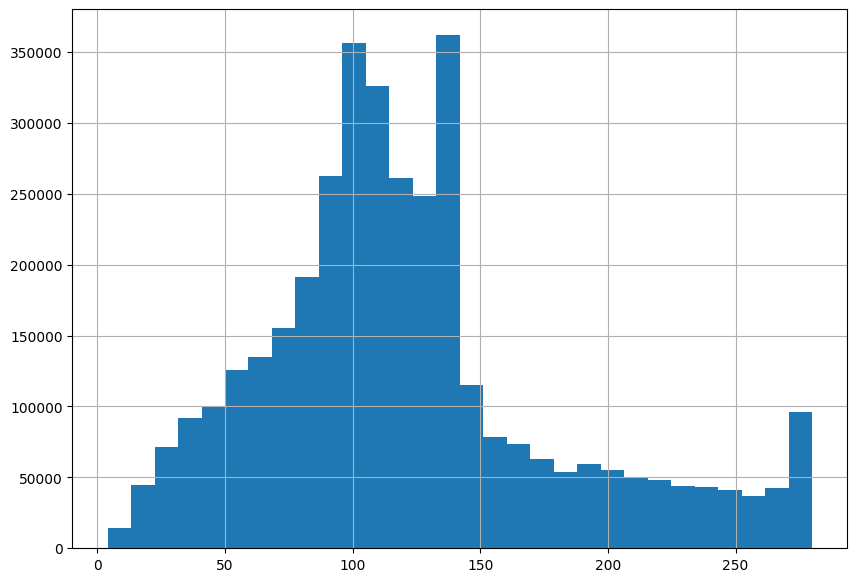

In [13]:
tweets_df.body.str.len()[tweets_df.body.str.len() <= 280].hist(bins=30, figsize=(10,7));
tweets_df.body.str.len()[tweets_df.body.str.len() <= 280].mean()

In order to combine datasets correctly we need to use inner join method, because for one tweet id we can have multiple tickers mentioned.

In [14]:
merged_df = pd.merge(tickers_df, tweets_df, how='inner')
merged_df = pd.merge(company_name_df, merged_df, how='inner')
merged_df

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,AAPL,apple,550803612197457920,SentiQuant,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,AAPL,apple,550803610825928706,SentiQuant,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
2,AAPL,apple,550803225113157632,MacHashNews,2015-01-01 23:58:16,Rumor Roundup: What to expect when you're expe...,0,0,0
3,AAPL,apple,550802957370159104,WaltLightShed,2015-01-01 23:57:13,"An $AAPL store line in Sapporo Japan for the ""...",2,4,4
4,AAPL,apple,550802855129382912,2waystrading,2015-01-01 23:56:48,$AAPL - Will $AAPL Give Second entry opportuni...,0,0,0
...,...,...,...,...,...,...,...,...,...
4336440,MSFT,Microsoft,1212122611192336394,LadeBackk,2019-12-31 21:25:25,$MSFT check the timestamp.... buy the dip and ...,0,1,3
4336441,MSFT,Microsoft,1212131912585826305,robintrack,2019-12-31 22:02:22,Top increases in popularity for stocks held by...,0,0,2
4336442,MSFT,Microsoft,1212145214736875520,MarketCurrents,2019-12-31 22:55:14,"$AAPL $MSFT $JPM - Apple, Microsoft top Dow 20...",0,0,2
4336443,MSFT,Microsoft,1212146425607413761,SentimEntropy,2019-12-31 23:00:03,Notable activity on social media recently for$...,0,0,0


In [15]:
merged_df.nunique()

ticker_symbol          6
company_name           5
tweet_id         3717964
writer            140131
post_date        3421363
body             3326194
comment_num          191
retweet_num          509
like_num             783
dtype: int64

In [16]:
tweets_df.nunique()

tweet_id       3717964
writer          140131
post_date      3421363
body           3326194
comment_num        191
retweet_num        509
like_num           783
dtype: int64

Number of unique values has not changed - merge was correct.

Now let's explore the merged dataframe:

In [17]:
def merge_chart_make(arg, title, aggregator=None):
    if aggregator == 'sum':
        merged_df.groupby(['company_name', pd.Grouper(key='post_date', freq='W')]).sum().reset_index().pivot(
        'post_date','company_name',arg).plot(title=title, grid=True, figsize=(17,7))
    else:
        merged_df.groupby(['company_name', pd.Grouper(key='post_date', freq='W')]).count().reset_index().pivot(
        'post_date','company_name',arg).plot(title=title, grid=True, figsize=(17,7))

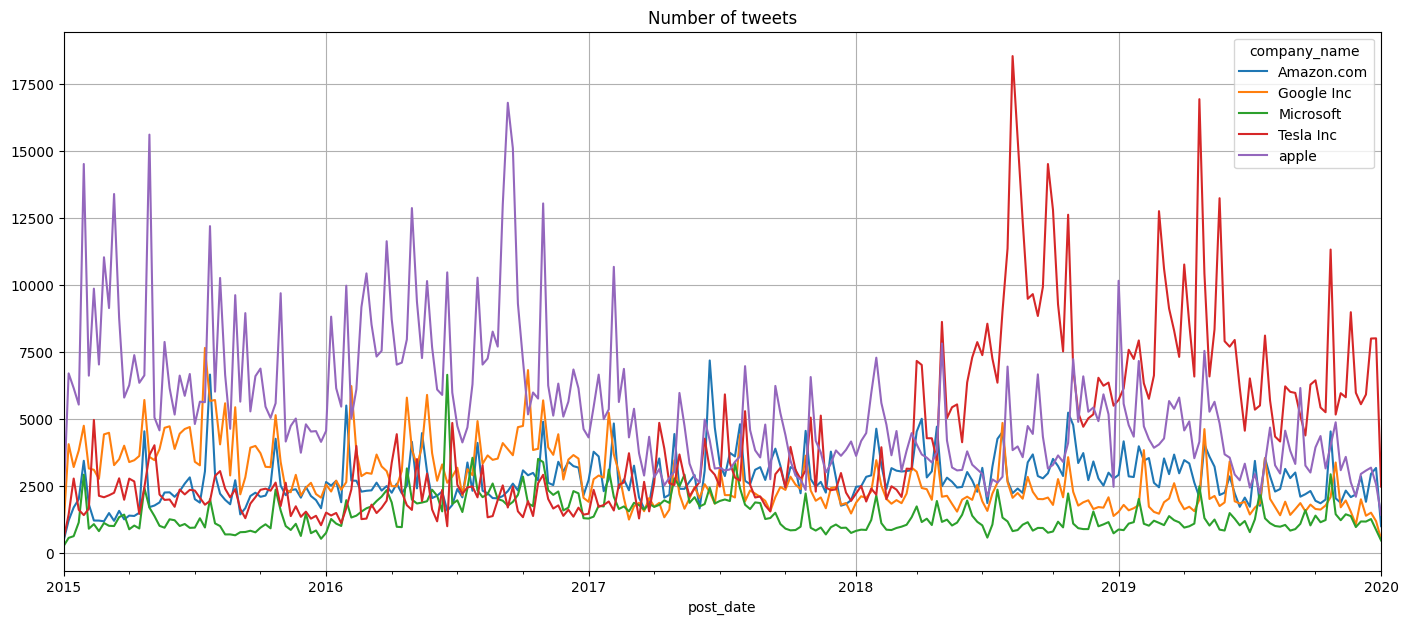

In [18]:
merge_chart_make(arg='tweet_id', title='Number of tweets');

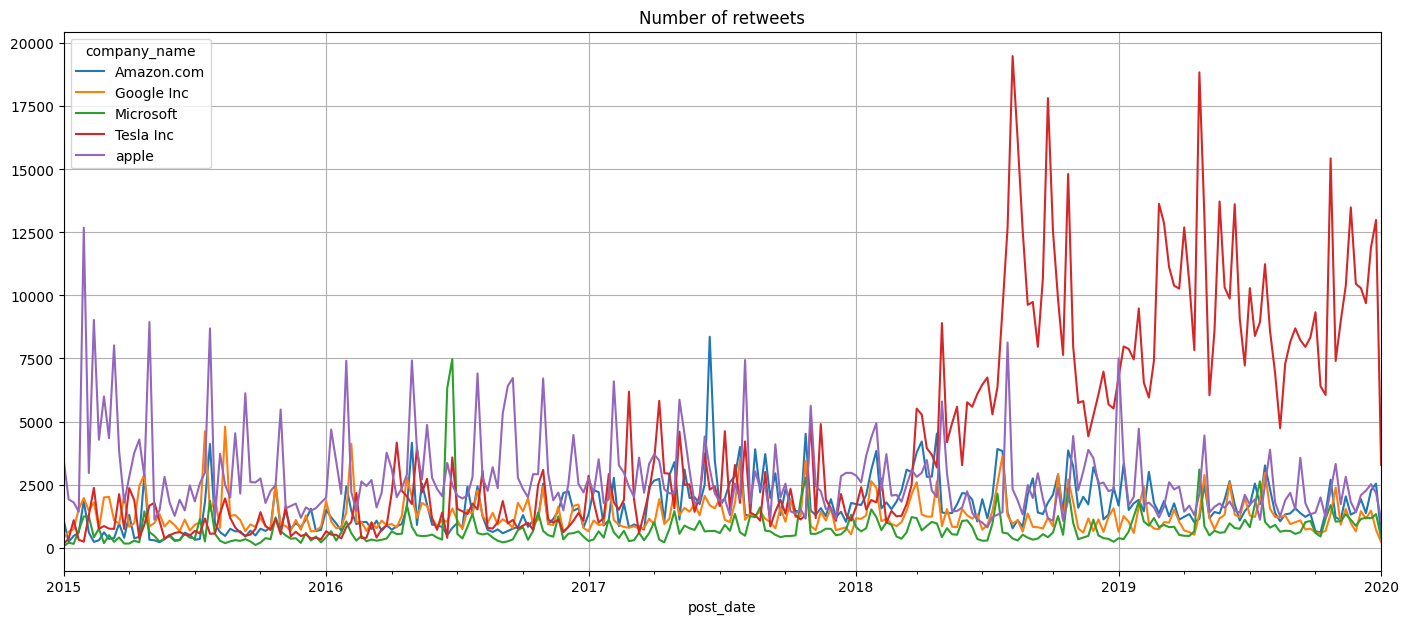

In [19]:
merge_chart_make(arg='retweet_num', title='Number of retweets', aggregator='sum');

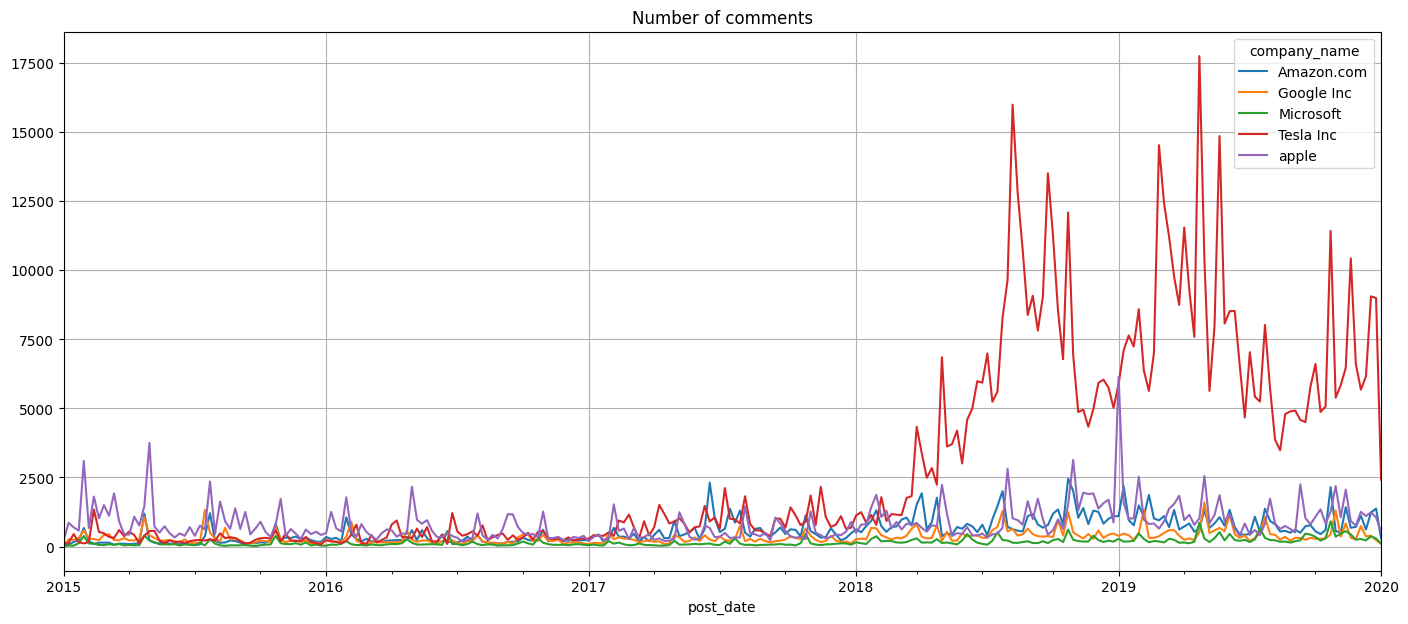

In [20]:
merge_chart_make(arg='comment_num', title='Number of comments', aggregator='sum');

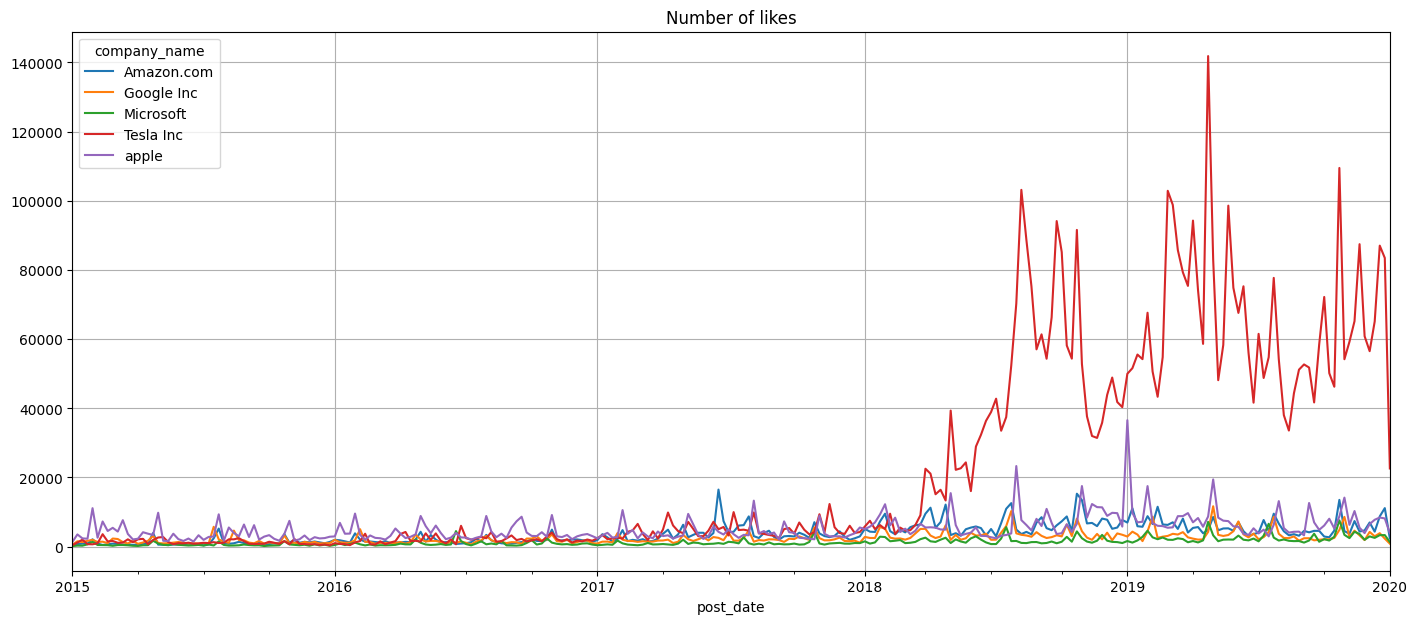

In [21]:
merge_chart_make(arg='like_num', title='Number of likes', aggregator='sum');

## Yahoo Data

In [22]:
def create_price_graph():
    AAPL = AAPL_stock.Close
    GOOG = GOOG_stock.Close
    GOOGL = GOOGL_stock.Close
    AMZN = AMZN_stock.Close
    TSLA = TSLA_stock.Close

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(10,7))

    ax.grid()
    ax.set_title("Daily close price")

    ax.plot(AAPL.index, AAPL, label='AAPL')
    ax.plot(GOOG.index, GOOG, label='GOOG')
    ax.plot(GOOGL.index, GOOGL, label='GOOGL')
    ax.plot(AMZN.index, AMZN, label='AMZN')
    ax.plot(TSLA.index, TSLA, label='TSLA')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price ($)')

    ax.legend()

In [23]:
def create_volume_graph():
    AAPL = AAPL_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    GOOG = GOOG_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    GOOGL = GOOGL_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    AMZN = AMZN_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    TSLA = TSLA_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(10,7))

    ax.grid()
    ax.set_title("Daily volume")

    ax.bar(AAPL.index, AAPL, label='AAPL', width=5)
    ax.bar(TSLA.index, TSLA, label='TSLA', width=5)
    ax.bar(AMZN.index, AMZN, label='AMZN', width=5)
    ax.bar(GOOGL.index, GOOGL, label='GOOGL', width=5)
    ax.bar(GOOG.index, GOOG, label='GOOG', width=5)

    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')

    ax.legend()

In [24]:
tickers = company_name_df.ticker_symbol.tolist()
tickers


['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'TSLA', 'MSFT']

### APPL

In [25]:
AAPL_stock = yf.Ticker(tickers[0]).history(start="2015-01-01", end="2020-01-01")
AAPL_stock.to_csv(f"Datasets/yfinance/{tickers[0]}.csv")
AAPL_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,25.066777,25.078029,24.157630,24.603203,212818400,0.0,0
2015-01-05 00:00:00-05:00,24.369169,24.450182,23.721066,23.910095,257142000,0.0,0
2015-01-06 00:00:00-05:00,23.975354,24.175636,23.545534,23.912344,263188400,0.0,0
2015-01-07 00:00:00-05:00,24.123874,24.348910,24.011356,24.247644,160423600,0.0,0
2015-01-08 00:00:00-05:00,24.580707,25.237812,24.461436,25.179302,237458000,0.0,0


In [26]:
AAPL_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.0
mean,36.583496,36.905739,36.270625,36.602831,1.435996e+08,0.002500,0.0
std,11.249087,11.352950,11.169368,11.276574,7.153802e+07,0.019912,0.0
min,20.836204,21.222831,20.713503,20.914919,4.544800e+07,0.000000,0.0
25%,26.566140,26.817250,26.346276,26.534299,9.512290e+07,0.000000,0.0
50%,35.765798,36.144155,35.369859,35.734419,1.263050e+08,0.000000,0.0
75%,44.652183,45.027175,44.343072,44.684526,1.714582e+08,0.000000,0.0
max,71.300926,71.998948,70.909052,71.920570,6.488252e+08,0.192500,0.0


### GOOG

In [27]:
GOOG_stock = yf.Ticker(tickers[1]).history(start="2015-01-01", end="2020-01-01")
GOOG_stock.to_csv(f"Datasets/yfinance/{tickers[1]}.csv")
GOOG_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,26.378078,26.490770,26.133251,26.168653,28951268,0,0.0
2015-01-05 00:00:00-05:00,26.091366,26.144720,25.582764,25.623152,41196796,0,0.0
2015-01-06 00:00:00-05:00,25.679497,25.738087,24.983908,25.029282,57998800,0,0.0
2015-01-07 00:00:00-05:00,25.280592,25.292759,24.914099,24.986401,41301082,0,0.0
2015-01-08 00:00:00-05:00,24.831326,25.105074,24.482782,25.065184,67071641,0,0.0


In [28]:
GOOG_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.000000
mean,45.666494,46.054933,45.277309,45.680669,3.413936e+07,0.0,0.000797
std,11.533924,11.639594,11.452816,11.550799,1.697264e+07,0.0,0.028272
min,24.664783,24.730902,24.311253,24.560070,6.950000e+06,0.0,0.000000
25%,36.463751,36.745375,36.125436,36.466002,2.425600e+07,0.0,0.000000
50%,46.486500,46.715250,46.176624,46.473249,2.976300e+07,0.0,0.000000
75%,55.632999,56.213625,55.222587,55.760251,3.898500e+07,0.0,0.000000
max,68.167503,68.250000,67.633499,68.058502,2.232980e+08,0.0,1.002746


### GOOGL

In [29]:
GOOGL_stock = yf.Ticker(tickers[2]).history(start="2015-01-01", end="2020-01-01")
GOOGL_stock.to_csv(f"Datasets/yfinance/{tickers[2]}.csv")
GOOGL_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,26.629999,26.790001,26.393999,26.477501,26480000,0,0
2015-01-05 00:00:00-05:00,26.357500,26.399500,25.887501,25.973000,41182000,0,0
2015-01-06 00:00:00-05:00,26.025000,26.060499,25.277500,25.332001,54456000,0,0
2015-01-07 00:00:00-05:00,25.547501,25.574499,25.182501,25.257500,46918000,0,0
2015-01-08 00:00:00-05:00,25.075500,25.375000,24.750999,25.345501,73054000,0,0


In [30]:
GOOGL_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0
mean,46.350680,46.741645,45.939285,46.354110,3.726109e+07,0.0,0.0
std,11.287292,11.386466,11.200538,11.298248,1.885330e+07,0.0,0.0
min,24.962000,25.014000,24.545500,24.853001,1.041200e+07,0.0,0.0
25%,37.448502,37.749876,37.078999,37.479752,2.625400e+07,0.0,0.0
50%,47.366251,47.636999,47.002499,47.377249,3.269300e+07,0.0,0.0
75%,55.950376,56.560374,55.556499,56.019501,4.199000e+07,0.0,0.0
max,68.199997,68.352501,67.650002,68.123497,2.571620e+08,0.0,0.0


### AMZN

In [31]:
AMZN_stock = yf.Ticker(tickers[3]).history(start="2015-01-01", end="2020-01-01")
AMZN_stock.to_csv(f"Datasets/yfinance/{tickers[3]}.csv")
AMZN_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,15.6290,15.7375,15.3480,15.4260,55664000,0,0
2015-01-05 00:00:00-05:00,15.3505,15.4190,15.0425,15.1095,55484000,0,0
2015-01-06 00:00:00-05:00,15.1120,15.1500,14.6190,14.7645,70380000,0,0
2015-01-07 00:00:00-05:00,14.8750,15.0640,14.7665,14.9210,52806000,0,0
2015-01-08 00:00:00-05:00,15.0160,15.1570,14.8055,15.0230,61768000,0,0


In [32]:
AMZN_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0
mean,55.774627,56.274166,55.177382,55.752367,8.380145e+07,0.0,0.0
std,26.625267,26.851819,26.321770,26.596442,4.501685e+07,0.0,0.0
min,14.314000,14.539500,14.262500,14.347500,1.762600e+07,0.0,0.0
25%,33.284624,33.747499,32.969000,33.239624,5.472550e+07,0.0,0.0
50%,48.577499,48.818001,48.073252,48.394751,7.147900e+07,0.0,0.0
75%,84.037502,84.998751,83.074999,83.847622,9.746950e+07,0.0,0.0
max,101.905502,102.525002,100.650002,101.975502,4.771220e+08,0.0,0.0


### TSLA

In [33]:
TSLA_stock = yf.Ticker(tickers[4]).history(start="2015-01-01", end="2020-01-01")
TSLA_stock.to_csv(f"Datasets/yfinance/{tickers[4]}.csv")
TSLA_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,14.858000,14.883333,14.217333,14.620667,71466000,0,0
2015-01-05 00:00:00-05:00,14.303333,14.433333,13.810667,14.006000,80527500,0,0
2015-01-06 00:00:00-05:00,14.004000,14.280000,13.614000,14.085333,93928500,0,0
2015-01-07 00:00:00-05:00,14.223333,14.318667,13.985333,14.063333,44526000,0,0
2015-01-08 00:00:00-05:00,14.187333,14.253333,14.000667,14.041333,51637500,0,0


In [34]:
MSFT_stock = yf.Ticker(tickers[5]).history(start="2015-01-01", end="2020-01-01")
MSFT_stock.to_csv(f"Datasets/yfinance/{tickers[5]}.csv")
MSFT_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,40.838914,41.504099,40.733886,40.926437,27913900,0.0,0
2015-01-05 00:00:00-05:00,40.585094,40.900183,40.480066,40.550087,39673900,0.0,0
2015-01-06 00:00:00-05:00,40.593842,40.917682,39.858637,39.954914,36447900,0.0,0
2015-01-07 00:00:00-05:00,40.243759,40.663876,39.814891,40.462570,29114100,0.0,0
2015-01-08 00:00:00-05:00,40.917691,41.792936,40.891435,41.652897,29645200,0.0,0


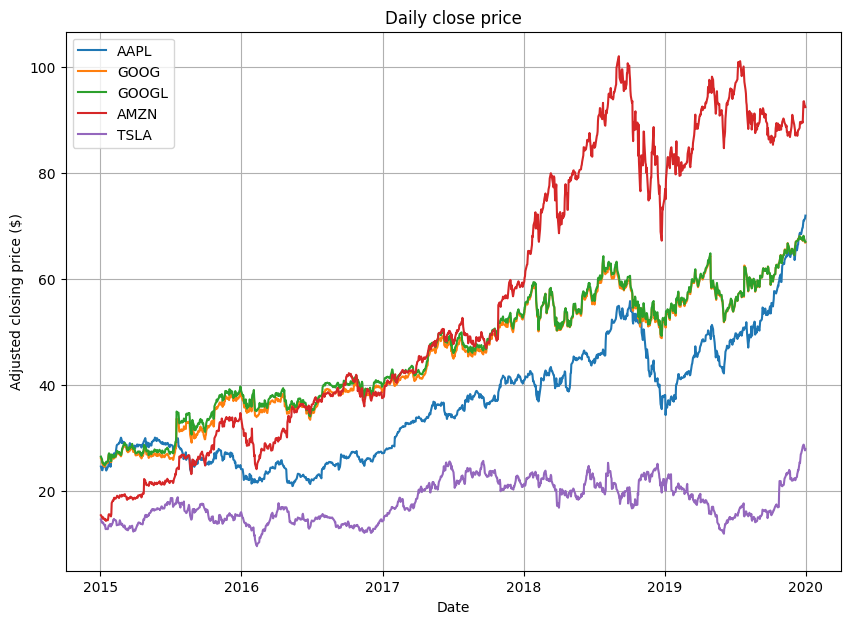

In [35]:
create_price_graph()

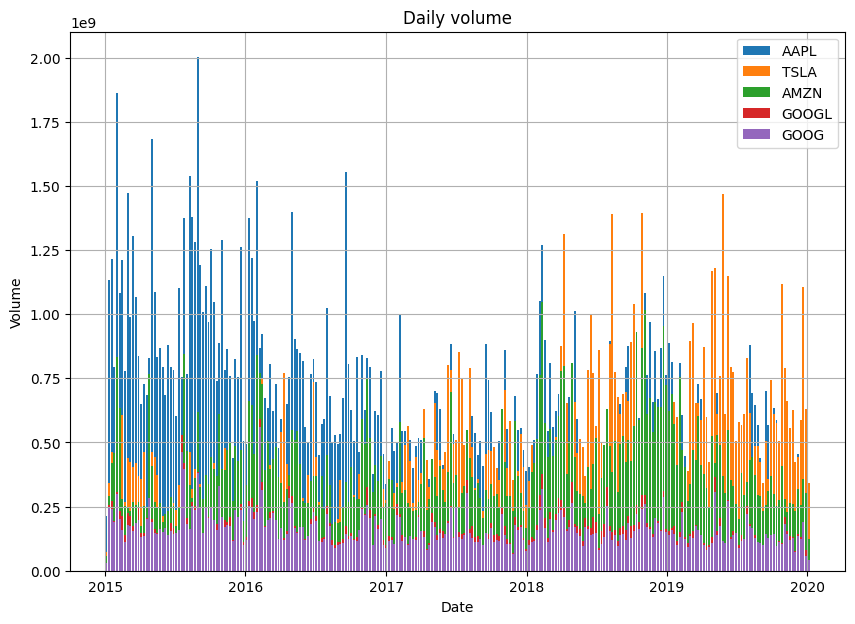

In [36]:
create_volume_graph()

## Combined

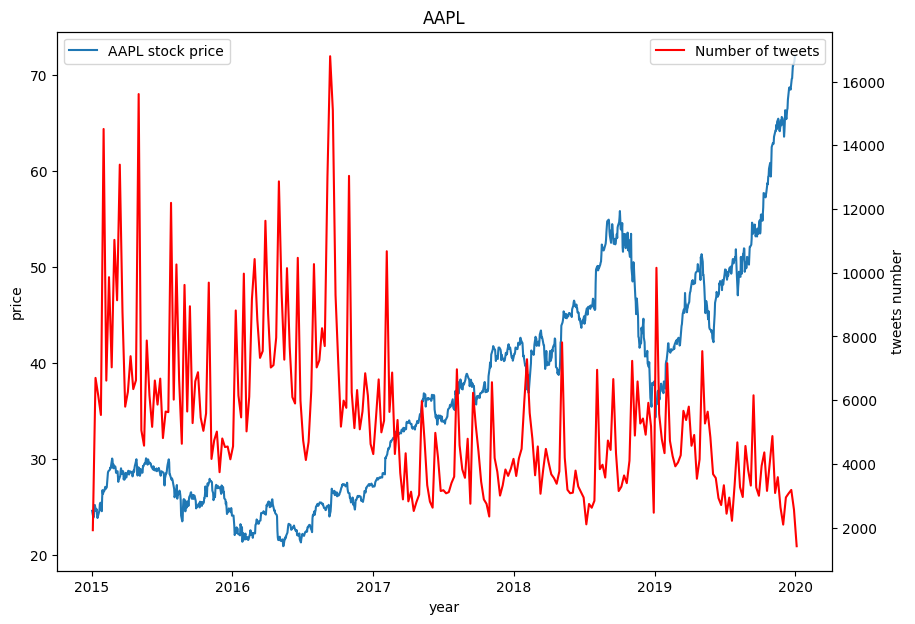

In [37]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(AAPL_stock.Close, label='AAPL stock price')
ax.set_title('AAPL')
plt.legend()
ax.set_xlabel('year')
ax.set_ylabel('price')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'AAPL'].groupby(pd.Grouper(key='post_date', axis=0, freq='1w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
plt.legend();

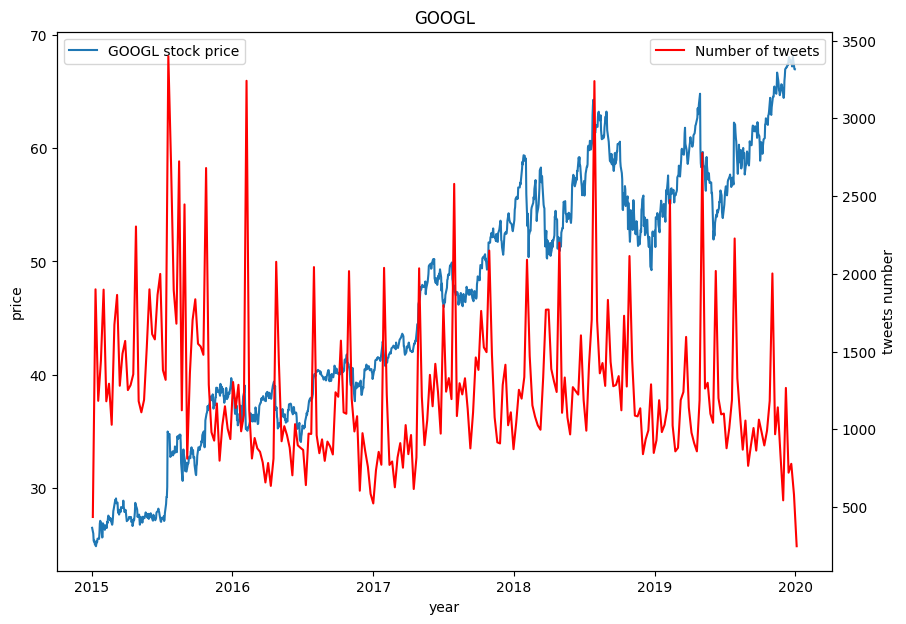

In [38]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(GOOGL_stock.Close, label='GOOGL stock price')
ax.set_title('GOOGL')
plt.legend()
ax.set_xlabel('year')
ax.set_ylabel('price')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'GOOGL'].groupby(pd.Grouper(key='post_date', axis=0, freq='1w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
plt.legend();

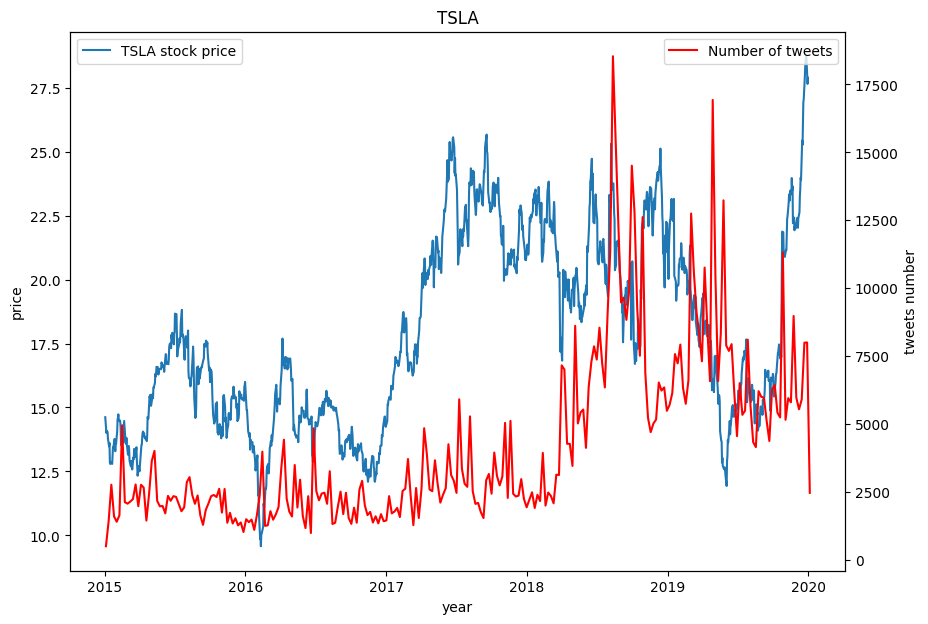

In [39]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(TSLA_stock.Close, label='TSLA stock price')
ax.set_title('TSLA')
plt.legend()
ax.set_xlabel('year')
ax.set_ylabel('price')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'TSLA'].groupby(pd.Grouper(key='post_date', axis=0, freq='1w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
plt.legend();

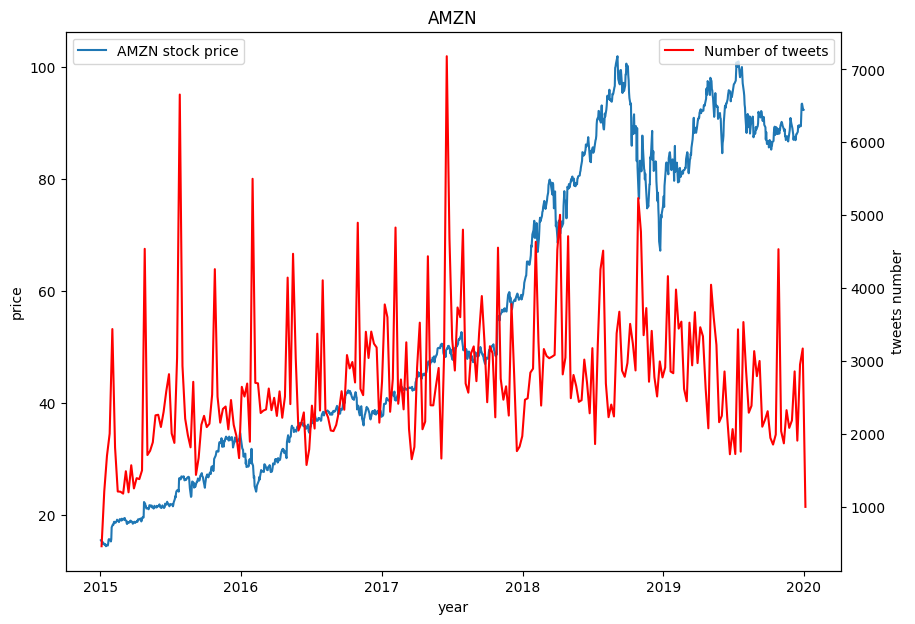

In [40]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(AMZN_stock.Close, label='AMZN stock price')
ax.set_title('AMZN')
plt.legend()
ax.set_xlabel('year')
ax.set_ylabel('price')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'AMZN'].groupby(pd.Grouper(key='post_date', axis=0, freq='1w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
plt.legend();